In [6]:
# run the header that sets up the environment

if "already_run" not in globals():
    globals()["already_run"] = True
    
    %run header.ipynb
    load_packages()
    change_wordir()
colors, colours = colourblind_palette("own")

analysis = "pfd_dynamics"

model = "cyclic_2021"
#model = "new_PSI"
#model = "new_PSII"
#model = "latest_dev"

m = load_model(model)


succesfully loaded cyclic_2021 :D


In [2]:
# set up model with new initial conditions

y0 = {
    "PQ": 11.027139850905353,       "PC": 1.8895071932002812,           "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,       "NADPH": 0.48821037006737366,       "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,      "Psbs": 0.9607146039898598,         "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,      "BPGA": 0.0005355311557548053,      "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,    "FBP": 0.006126990841013743,        "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,      "G1P": 0.041575582577936025,        "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,     "E4P": 0.00732079113061801,         "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,     "RUBP": 0.13153657267999222,        "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,    "ASC": 9.999994138785292,           "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,   "GSH": 9.999999991725186,           "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,                   "E_inactive": 4.7368421052631575,
    "P700FA": 1.506615384275408,            #eq at pfd 800       #"PSItot": 2.5, (in parameter vector of Matuszynska)
    "P700+FA-": 0.019197449388051676,
    "P700FA-": 0.028144516332212766,
    "B0": 1.9379789566530539,  # eq at pfd 800
    "B1": 9.786232812526368e-08,
    "B2": 0.5620208537555176
}

s = Simulator(m)

s.update_parameter("pfd", 800)
s.initialise(y0)
s.simulate_to_steady_state()
y1 = s.get_new_y0()

In [3]:
def simulate_change(s, y0, param, value1, value2, t_to_0, t_after_0):
    """
    Simulate a change in a parameter from value1 to value2, starting at 0. Change appears at "t_to_0".
    """
    #get steady state
    s.update_parameter(param, value1)
    s.initialise(y0)
    s.simulate_to_steady_state()
    y1 = s.get_new_y0()
    if y1 is None:
        # throw error if steady state not reached
        raise ValueError("Modelbase says NO")

    # include some seconds before change
    s.initialise(y1)
    s.simulate(t_to_0)

    # simulate change
    s.update_parameter(param, value2)
    s.simulate(t_after_0)
    
    return None

# dark to light

In [4]:
# DARK TO LIGHT TRANSITION

pfd_dark = 30
pfd_light = 1000
t_to_0 = 5
t_after_0 = 100
#t_borders = [0, 100]
t_borders = [4.998, 5.008]
t_dark = [0, 5]

simulate_change(s, y1, "pfd", pfd_dark, pfd_light, t_to_0, t_after_0)

c = s.get_full_results_df()

In [5]:
c = checkpoint("c", dir = f"{model}/{analysis}", filename = "c_dark_to_light")

Saved: data/latest_dev/pfd_dynamics\c_dark_to_light.joblib


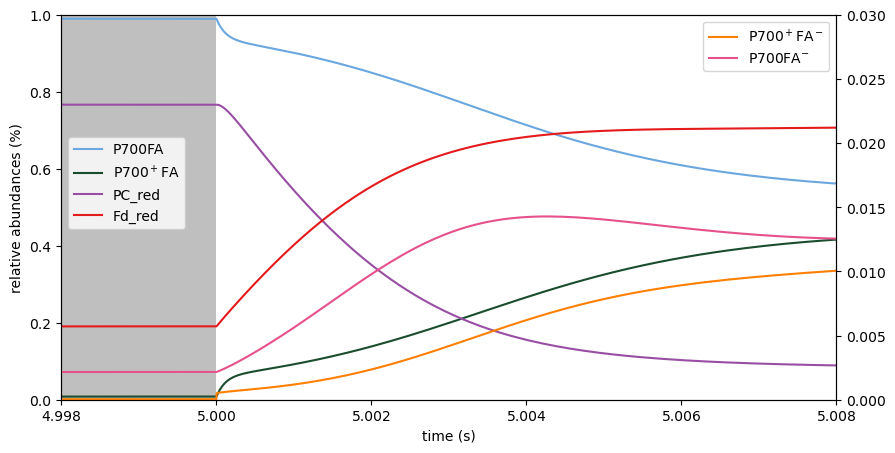

In [7]:
# PLOT PSI STATES

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax2 = ax1.twinx()

ax1.plot(c["rel_P700FA"], label="P700FA", color=colors[0])
ax2.plot(c["rel_P700+FA-"], label="P700$^+$FA$^-$", color=colors[1])
ax1.plot(c["rel_P700+FA"], label="P700$^+$FA", color =colors[2])

if model != "cyclic_2021":
    ax2.plot(c["rel_P700FA-"], label = "P700FA$^{-}$", color=colors[3])

ax1.plot(c["PC_redoxstate"], label="PC_red", color=colors[4])
ax1.plot(c["Fd_redoxstate"], label="Fd_red", color=colors[5])

ax1.axvspan(t_dark[0], t_dark[1], facecolor='grey', alpha=0.5)

ax1.set(xlim=t_borders,
        ylim=(-0.00, 1),
        xlabel=("time (s)"),
        ylabel=("relative abundances (%)"))
ax2.set(ylim=(-0.0, 0.03)
    )

#legends
ax1.legend(loc="upper left", bbox_to_anchor=(0, 0.7))
ax2.legend(loc = "upper right", bbox_to_anchor=(1, 1))


In [8]:
folder = f"figures/{model}/pfd_dynamics/"
zoom = ""
zoom = "_zoom_into_instant"

save_fig(fig, model, analysis, f"PSI_dark_light_{pfd_dark}_{pfd_light}{zoom}")

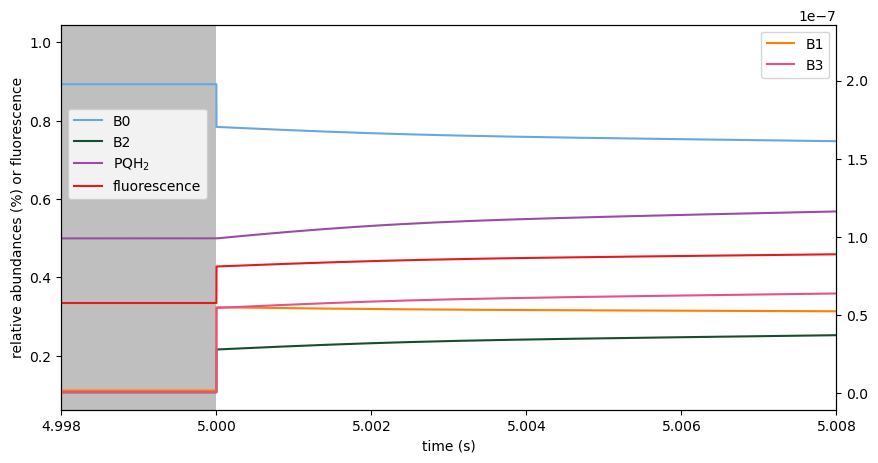

In [7]:
# PLOT PSII STATES

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax2 = ax1.twinx()

ax1.plot(c["rel_B0"], label="B0", color=colors[0])
ax2.plot(c["rel_B1"], label="B1", color=colors[1])
ax1.plot(c["rel_B2"], label="B2", color=colors[2])
ax2.plot(c["rel_B3"], label="B3", color=colors[3])

ax1.plot(c["PQ_redoxstate"], label="PQH$_2$", color=colors[4])
ax1.plot(c["Fluo"]/max(c["Fluo"]), label="fluorescence", color=colors[5])

ax1.axvspan(t_dark[0], t_dark[1], facecolor='grey', alpha=0.5)

ax1.set(xlim=t_borders,
        #ylim=(-0.00, 1),
        xlabel=("time (s)"),
        ylabel=("relative abundances (%) or fluorescence"))
ax2.set()

#legends
ax1.legend(loc="upper left", bbox_to_anchor=(0, 0.8))
ax2.legend(loc = "upper right", bbox_to_anchor=(1, 1))

In [8]:
folder = f"figures/{model}/pfd_dynamics/"
zoom = ""
zoom = "_zoom_into_instant"

save_fig(fig, model, analysis, f"PSII_dark_light_{pfd_dark}_{pfd_light}{zoom}")

# light to dark

In [5]:
# analysing light to dark transition

pfd_dark = 30
pfd_light = 1000
t_to_0 = 5
t_after_0 = 100
#t_borders = [0, 100]
t_borders = [4.998, 5.008]
t_dark = [5, 100]

simulate_change(s, y1, "pfd", pfd_light, pfd_dark, t_to_0, t_after_0)

c = s.get_full_results_df()


In [7]:
c = checkpoint("c", dir = f"{model}/{analysis}", filename = "c_light_to_dark")

Saved: data/latest_dev/pfd_dynamics\c_light_to_dark.joblib


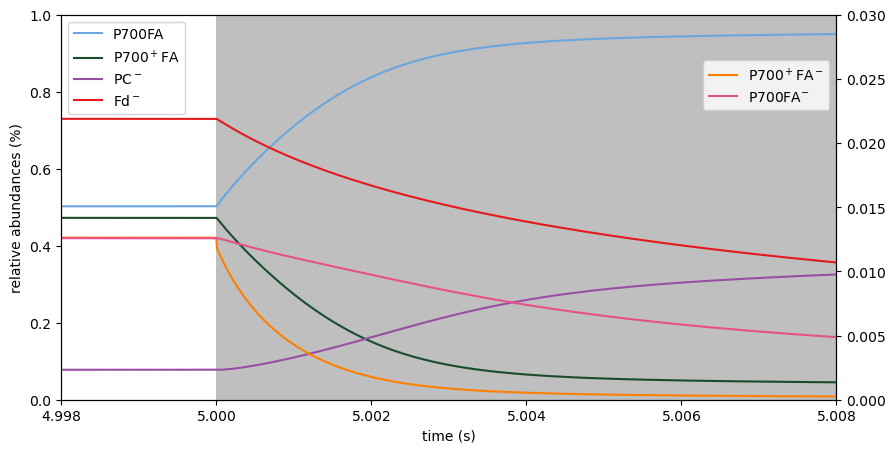

In [11]:
# PLOT PSI STATES

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax2 = ax1.twinx()

ax1.plot(c["rel_P700FA"], label="P700FA", color=colors[0])
ax2.plot(c["rel_P700+FA-"], label="P700$^+$FA$^-$", color=colors[1])
ax1.plot(c["rel_P700+FA"], label="P700$^+$FA", color =colors[2])

if model != "cyclic_2021":
    ax2.plot(c["rel_P700FA-"], label = "P700FA$^{-}$", color=colors[3])

ax1.plot(c["PC_redoxstate"], label="PC$^-$", color=colors[4])
ax1.plot(c["Fd_redoxstate"], label="Fd$^-$", color=colors[5])

ax1.axvspan(t_dark[0], t_dark[1], facecolor='grey', alpha=0.5)

ax1.set(xlim=t_borders,
        ylim=(-0.00, 1),
        xlabel=("time (s)"),
        ylabel=("relative abundances (%)"))
ax2.set(ylim=(-0.0, 0.03)),

#legends
ax1.legend(loc="upper left", bbox_to_anchor=(0, 1))
ax2.legend(loc = "upper right", bbox_to_anchor=(1, 0.9))

In [11]:
folder = f"figures/{model}/pfd_dynamics/"
zoom = ""
zoom = "_zoom_into_instant"

save_fig(fig, model, analysis, f"PSI_light_dark_{pfd_dark}_{pfd_light}{zoom}")

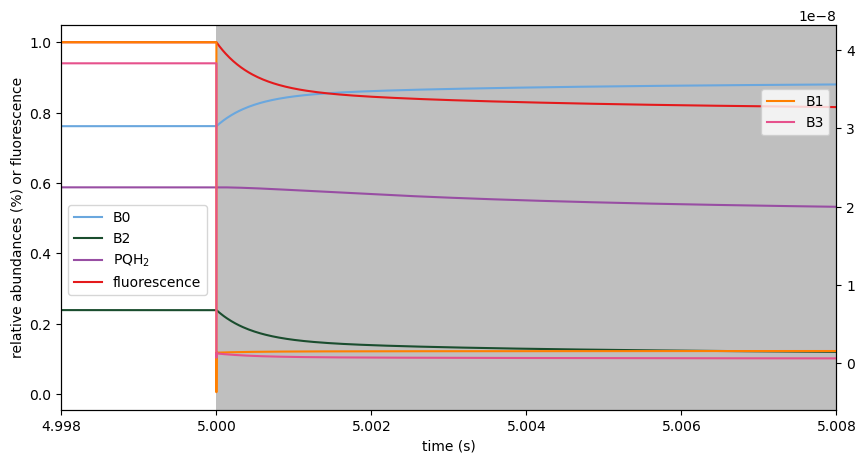

In [9]:
# PLOT PSII STATES

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax2 = ax1.twinx()

ax1.plot(c["rel_B0"], label="B0", color=colors[0])
ax2.plot(c["rel_B1"], label="B1", color=colors[1])
ax1.plot(c["rel_B2"], label="B2", color=colors[2])
ax2.plot(c["rel_B3"], label="B3", color=colors[3])

ax1.plot(c["PQ_redoxstate"], label="PQH$_2$", color=colors[4])
ax1.plot(c["Fluo"]/max(c["Fluo"]), label="fluorescence", color=colors[5])

ax1.axvspan(t_dark[0], t_dark[1], facecolor='grey', alpha=0.5)

ax1.set(xlim=t_borders,
        #ylim=(-0.00, 1),
        xlabel=("time (s)"),
        ylabel=("relative abundances (%) or fluorescence"))

#legends
ax1.legend(loc="upper left", bbox_to_anchor=(0, 0.55))
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.85))

In [13]:
save_fig(fig, model, analysis, f"PSII_light_dark_{pfd_dark}_{pfd_light}{zoom}")